In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
root_folder = 'FC_VAE_results'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(recon_folder)

In [5]:
mnist_sigmoid = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                lambda x: x.to(device)
           ])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_sigmoid)
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_x, _ = next(iter(test_loader))
fixed_x = fixed_x[:100].to(device)

cuda:0


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
data, label = next(iter(train_loader))

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_size=32, bn=False, lr=0.0001):
        super(VAE, self).__init__()
        self.encoder = FullyConnected([28*28, 1024, 1024, latent_size*2], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
        self.decoder = FullyConnected([latent_size, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Sigmoid(), device=device)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.name = 'VAE' + str(latent_size)
   
    def get_name(self):
        return self.name

    def encode(self, x):
        return self.encoder.forward(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder.forward(z)

    def forward(self, x):
        h = self.encode(x)
        mu, logvar = torch.chunk(h, 2, dim=1)  # mean and log variance.
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

    def loss(self, recon_x, x, mu, logvar):
        #print ('recon_x',recon_x)
        #print ('x',x)
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
        #print ('BCE=',BCE)

        KLD = 0.5 * torch.sum(logvar.exp() + mu * mu - 1 - logvar)
        #print ('KLD=',KLD)

        return BCE + KLD

In [10]:
batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [11]:
def train(model, epoch, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        model.optimizer.zero_grad()
        reconstructed, mu, logvar = model(data)
        loss = model.loss(reconstructed, data, mu, logvar)
        loss.backward()
        
        model.optimizer.step()
        
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = model.get_name() + ': {:.4f}'.format(loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = model.get_name() + ': {:.4f}'.format(loss.item())
        print(line + losses)
        if log is not None:
            log[model.get_name()].append((loss.item(),))

In [12]:
def test(model, loader, epoch, full_recon_folder, log=None):
    test_size = len(loader)
    test_loss[model.get_name()] = 0.
    with torch.no_grad():
        for data, _ in loader:
            reconstructed, mu, logvar = model(data)
            loss = model.loss(reconstructed, data, mu, logvar)
            test_loss[model.get_name()] += loss.item()
            
        test_loss[model.get_name()] /= test_size

        reconstruction, _, _ = model(fixed_x)
        reconstruction = reconstruction.cpu().data.numpy().reshape(-1, 1, 28, 28)
        plot_mnist(reconstruction, (10, 10), True, full_recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. {}: {:.4f}'.format(model.get_name(), test_loss[model.get_name()])
    print(report)
    if log is not None:
        log[model.get_name()].append((test_loss[model.get_name()],))

In [13]:
models = {'VAE2': VAE(2),
          'VAE32': VAE(32), 
          'VAE64': VAE(64)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [14]:
test_loss = {k: 0.0 for k in models}

Train Epoch: 1 [0/50000 (0%)]	Losses VAE2: 136181.9375
Train Epoch: 1 [25000/50000 (50%)]	Losses VAE2: -2250013.0000
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE2: -3424887.7500


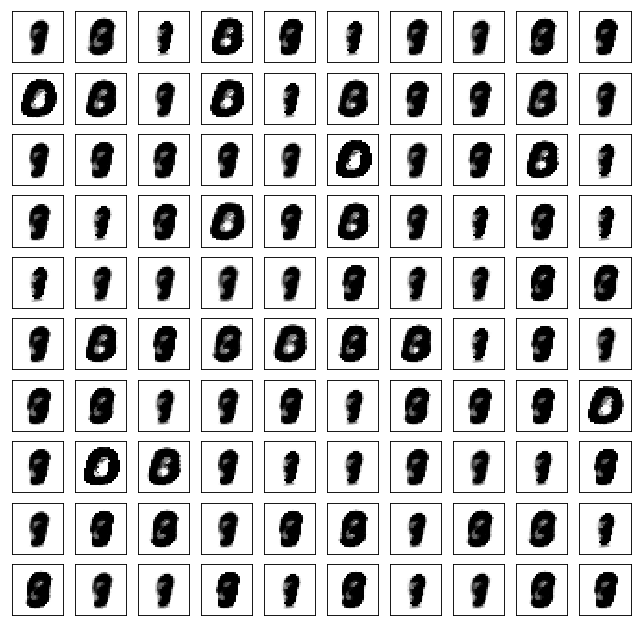

Test losses. VAE2: -3286504.3125
Train Epoch: 2 [0/50000 (0%)]	Losses VAE2: -3220060.2500
Train Epoch: 2 [25000/50000 (50%)]	Losses VAE2: -3646448.5000
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE2: -4058758.7500


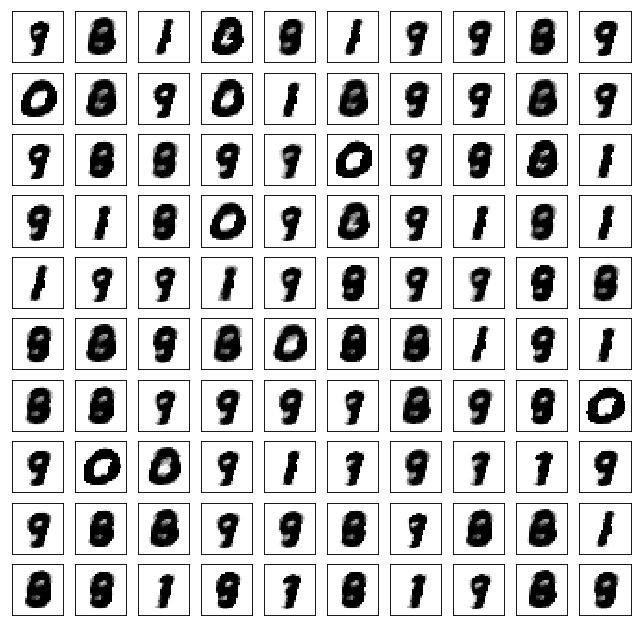

Test losses. VAE2: -4076587.4875
Train Epoch: 3 [0/50000 (0%)]	Losses VAE2: -3876125.0000
Train Epoch: 3 [25000/50000 (50%)]	Losses VAE2: -4421545.5000
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE2: -4844017.0000


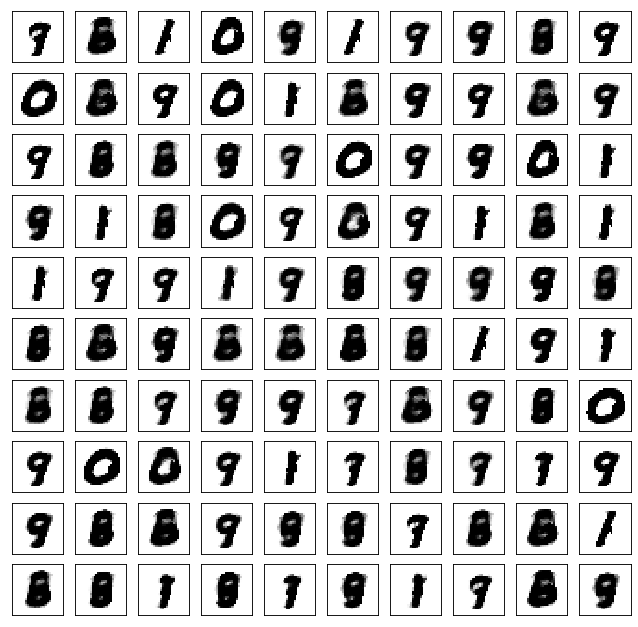

Test losses. VAE2: -4697747.0375
Train Epoch: 4 [0/50000 (0%)]	Losses VAE2: -4769494.0000
Train Epoch: 4 [25000/50000 (50%)]	Losses VAE2: -4903222.0000
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE2: -5191343.0000


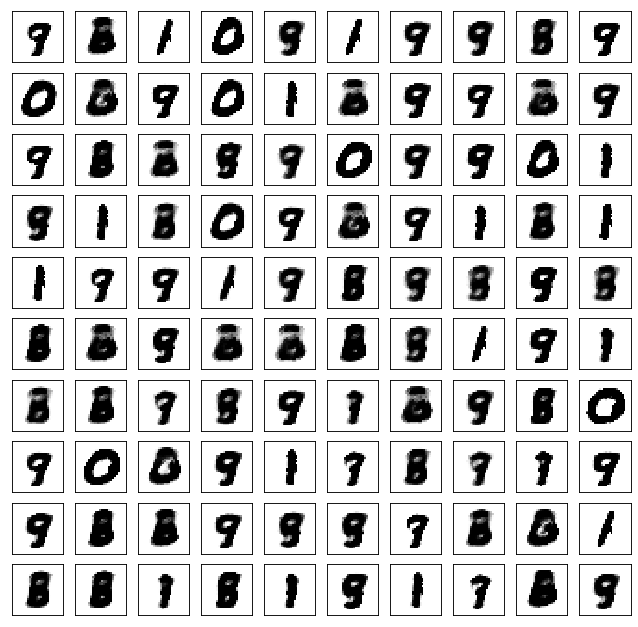

Test losses. VAE2: -5043895.0125
Train Epoch: 5 [0/50000 (0%)]	Losses VAE2: -5027367.0000
Train Epoch: 5 [25000/50000 (50%)]	Losses VAE2: -5131573.0000
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE2: -5417042.5000


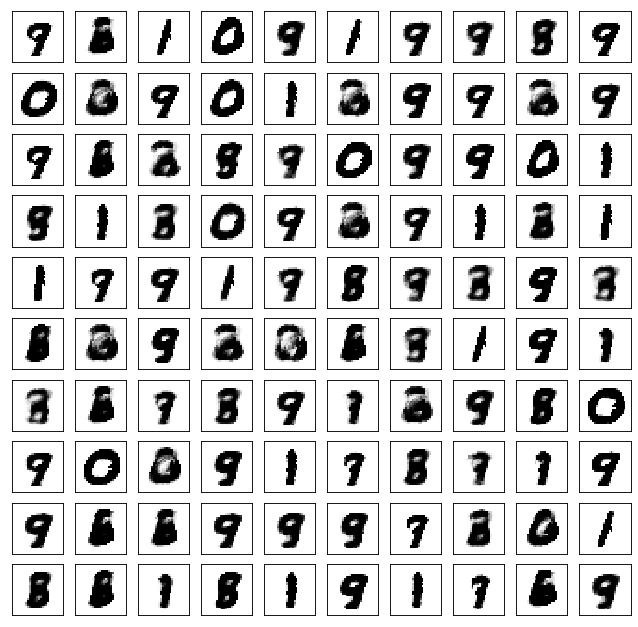

Test losses. VAE2: -5300160.8000
Train Epoch: 6 [0/50000 (0%)]	Losses VAE2: -5441075.5000
Train Epoch: 6 [25000/50000 (50%)]	Losses VAE2: -5574176.5000
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE2: -5325882.0000


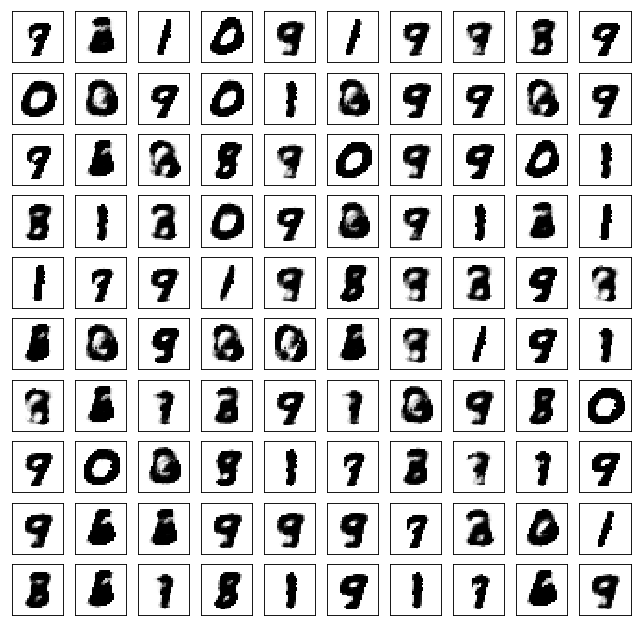

Test losses. VAE2: -5426471.1250
Train Epoch: 7 [0/50000 (0%)]	Losses VAE2: -5512249.5000
Train Epoch: 7 [25000/50000 (50%)]	Losses VAE2: -5903664.5000
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE2: -5605200.0000


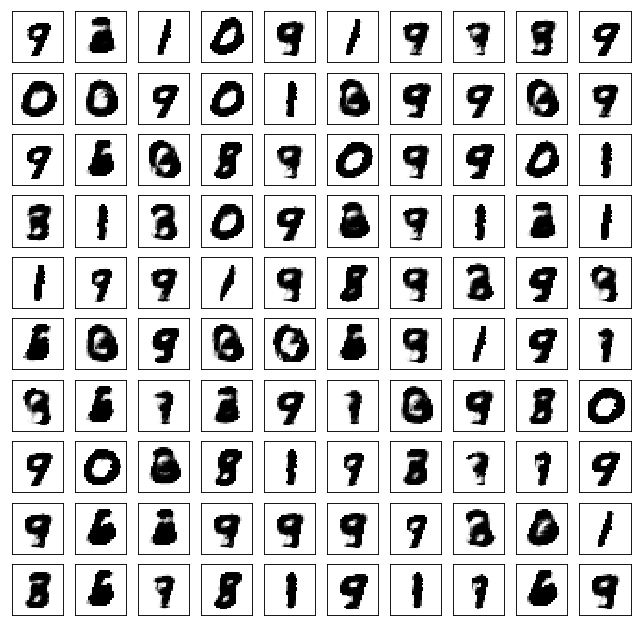

Test losses. VAE2: -5600704.8500
Train Epoch: 8 [0/50000 (0%)]	Losses VAE2: -5667385.5000
Train Epoch: 8 [25000/50000 (50%)]	Losses VAE2: -5581997.5000
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE2: -5930527.5000


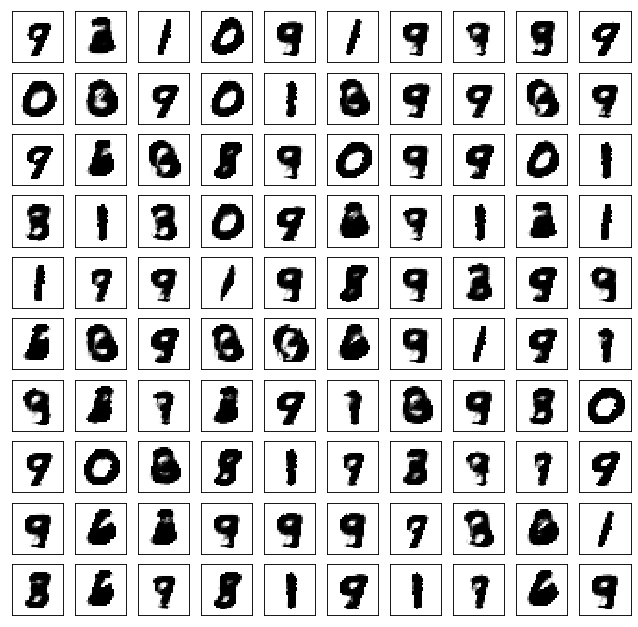

Test losses. VAE2: -5733558.0500
Train Epoch: 9 [0/50000 (0%)]	Losses VAE2: -6113874.5000
Train Epoch: 9 [25000/50000 (50%)]	Losses VAE2: -5833225.5000
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE2: -5626734.0000


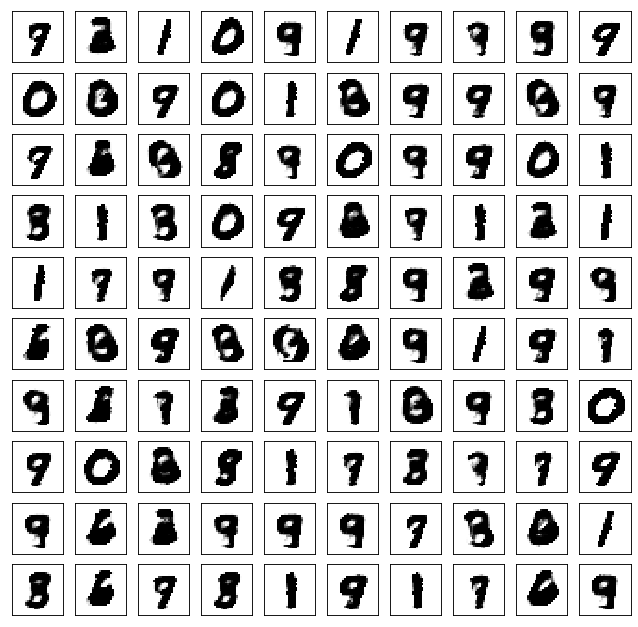

Test losses. VAE2: -5800656.6375
Train Epoch: 10 [0/50000 (0%)]	Losses VAE2: -5882573.0000
Train Epoch: 10 [25000/50000 (50%)]	Losses VAE2: -6022640.5000
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE2: -5890636.0000


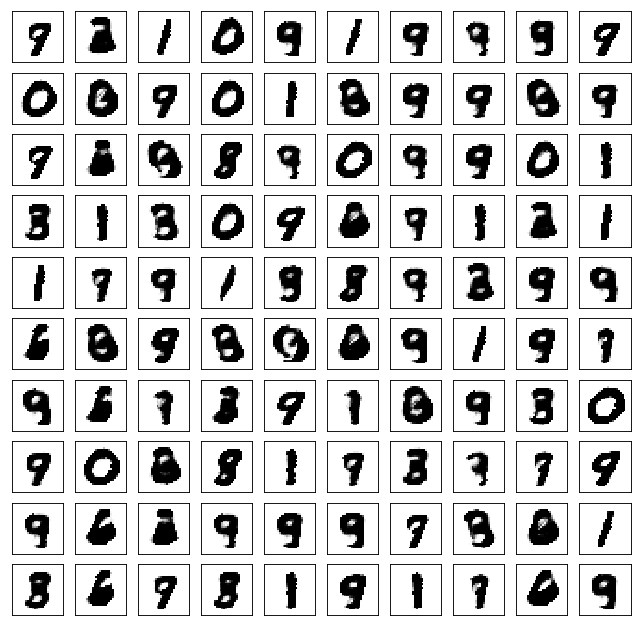

Test losses. VAE2: -5920363.2875
Train Epoch: 1 [0/50000 (0%)]	Losses VAE32: 136199.3281
Train Epoch: 1 [25000/50000 (50%)]	Losses VAE32: -1812614.0000
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE32: -2439736.5000


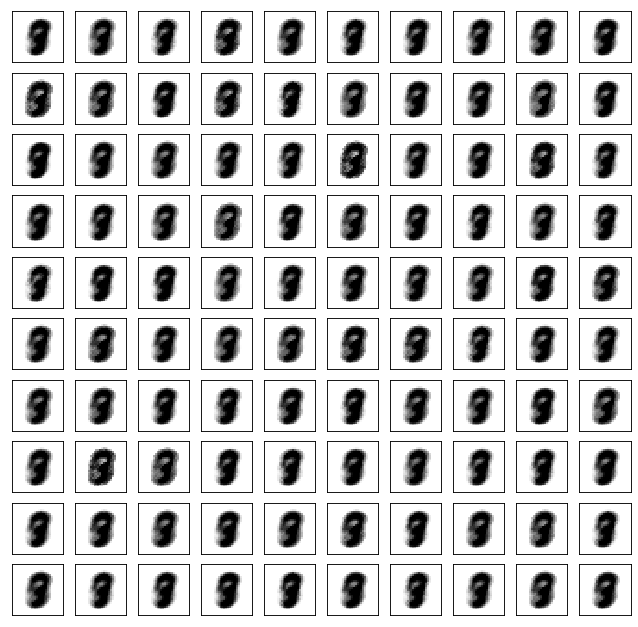

Test losses. VAE32: -2330587.3937
Train Epoch: 2 [0/50000 (0%)]	Losses VAE32: -2341957.2500
Train Epoch: 2 [25000/50000 (50%)]	Losses VAE32: -3298993.0000
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE32: -4800676.0000


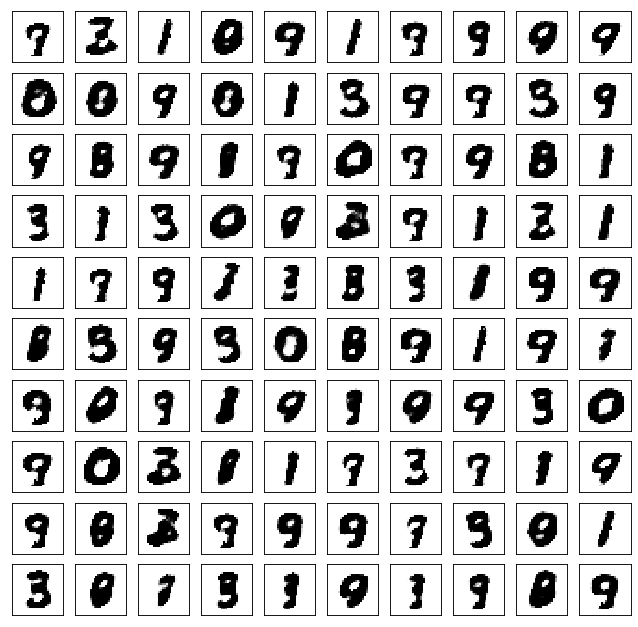

Test losses. VAE32: -4583767.6000
Train Epoch: 3 [0/50000 (0%)]	Losses VAE32: -4542319.0000
Train Epoch: 3 [25000/50000 (50%)]	Losses VAE32: -5420668.5000
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE32: -5651308.0000


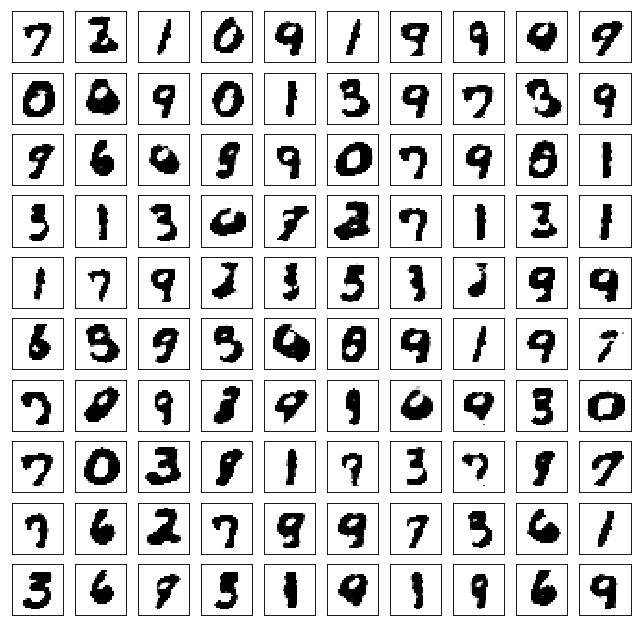

Test losses. VAE32: -5688567.7500
Train Epoch: 4 [0/50000 (0%)]	Losses VAE32: -5580161.0000
Train Epoch: 4 [25000/50000 (50%)]	Losses VAE32: -6134141.0000
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE32: -6140363.0000


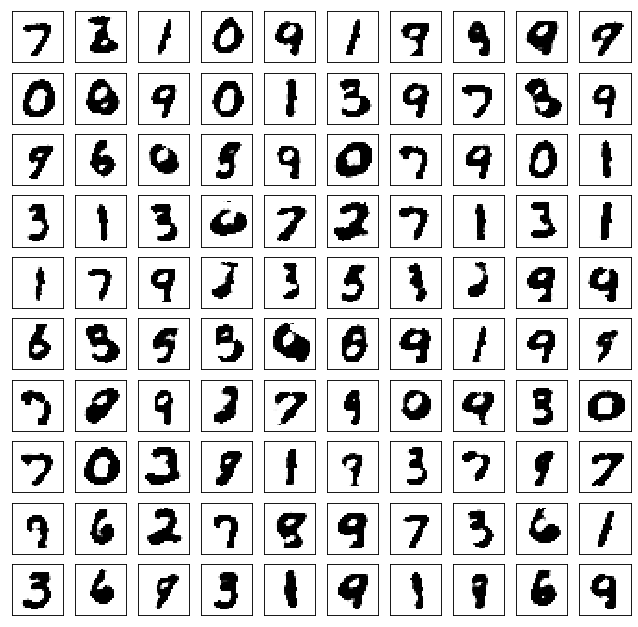

Test losses. VAE32: -6389800.4500
Train Epoch: 5 [0/50000 (0%)]	Losses VAE32: -6501115.5000
Train Epoch: 5 [25000/50000 (50%)]	Losses VAE32: -6657194.0000
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE32: -6841225.5000


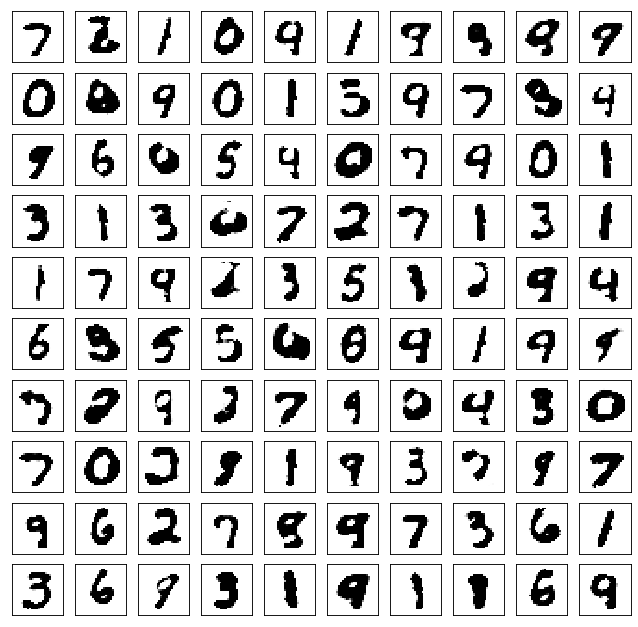

Test losses. VAE32: -6920643.7375
Train Epoch: 6 [0/50000 (0%)]	Losses VAE32: -6923935.5000
Train Epoch: 6 [25000/50000 (50%)]	Losses VAE32: -7201897.5000
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE32: -7335871.0000


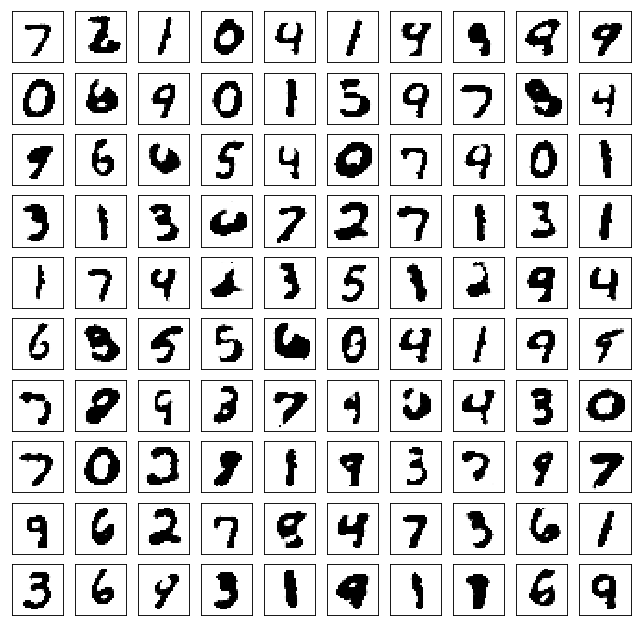

Test losses. VAE32: -7297385.8750
Train Epoch: 7 [0/50000 (0%)]	Losses VAE32: -7327029.0000
Train Epoch: 7 [25000/50000 (50%)]	Losses VAE32: -7335942.5000
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE32: -7567130.5000


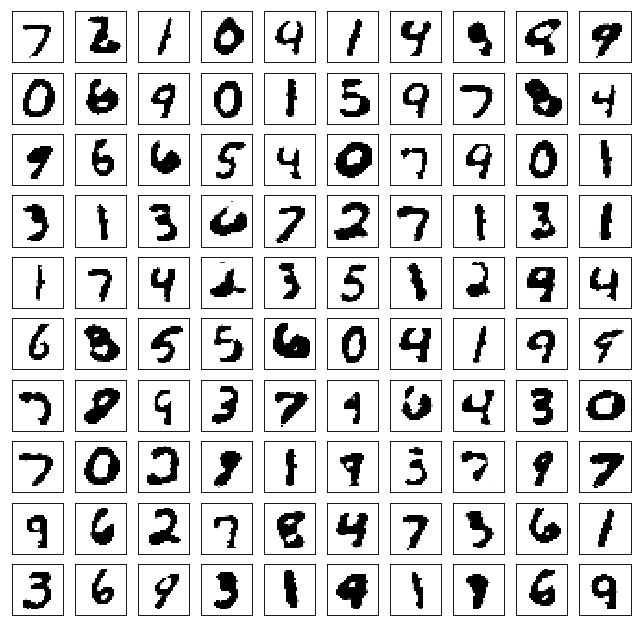

Test losses. VAE32: -7563956.3500
Train Epoch: 8 [0/50000 (0%)]	Losses VAE32: -7555851.5000
Train Epoch: 8 [25000/50000 (50%)]	Losses VAE32: -7648840.0000
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE32: -7692086.0000


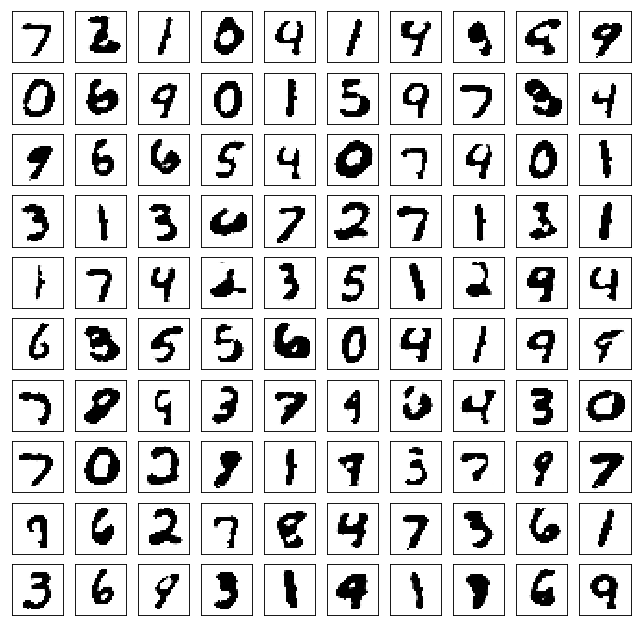

Test losses. VAE32: -7769974.1125
Train Epoch: 9 [0/50000 (0%)]	Losses VAE32: -7915193.0000
Train Epoch: 9 [25000/50000 (50%)]	Losses VAE32: -7814649.5000
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE32: -7905552.5000


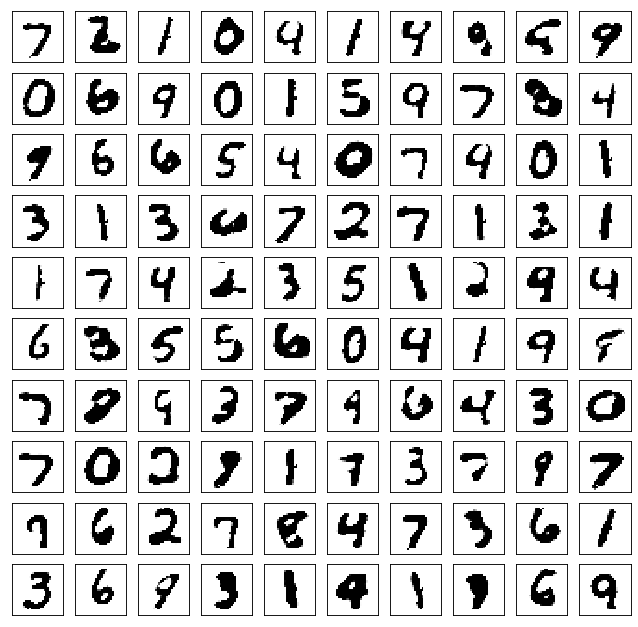

Test losses. VAE32: -7913834.1750
Train Epoch: 10 [0/50000 (0%)]	Losses VAE32: -7901526.5000
Train Epoch: 10 [25000/50000 (50%)]	Losses VAE32: -8065417.5000
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE32: -8175622.5000


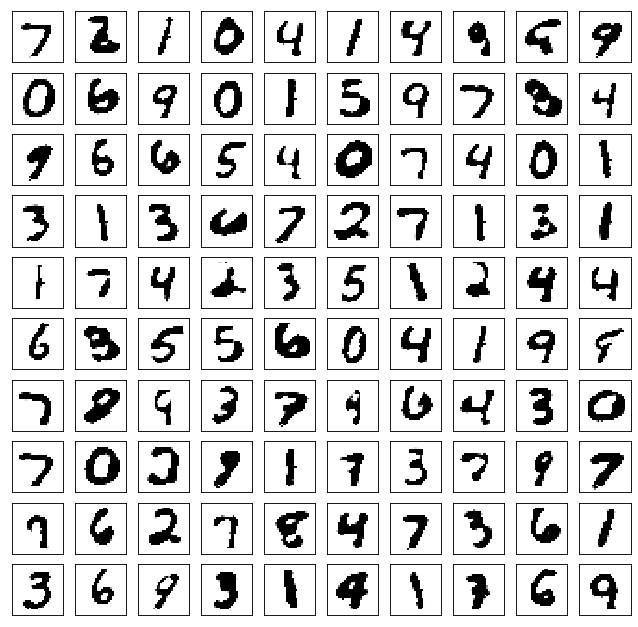

Test losses. VAE32: -8185754.0625
Train Epoch: 1 [0/50000 (0%)]	Losses VAE64: 136023.8125
Train Epoch: 1 [25000/50000 (50%)]	Losses VAE64: -1919398.8750
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE64: -2457549.2500


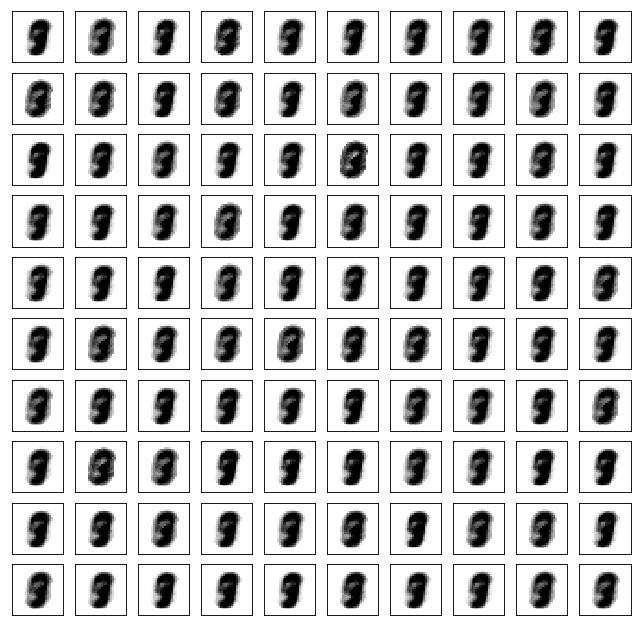

Test losses. VAE64: -2504080.6375
Train Epoch: 2 [0/50000 (0%)]	Losses VAE64: -2464459.2500
Train Epoch: 2 [25000/50000 (50%)]	Losses VAE64: -3588422.0000
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE64: -4581345.0000


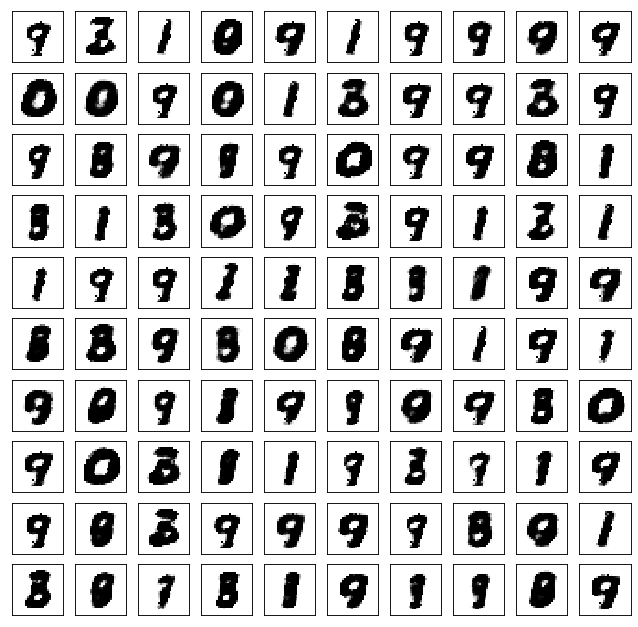

Test losses. VAE64: -4397806.8312
Train Epoch: 3 [0/50000 (0%)]	Losses VAE64: -4588728.0000
Train Epoch: 3 [25000/50000 (50%)]	Losses VAE64: -5365101.5000
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE64: -5669324.5000


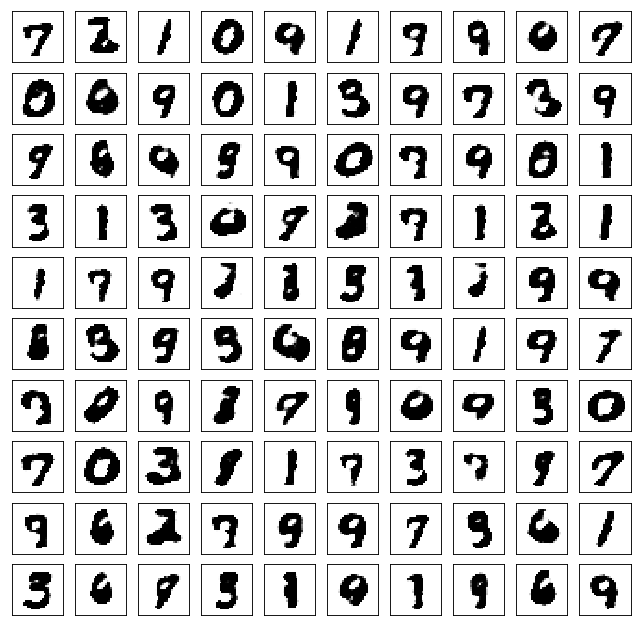

Test losses. VAE64: -5715371.0500
Train Epoch: 4 [0/50000 (0%)]	Losses VAE64: -5586444.0000
Train Epoch: 4 [25000/50000 (50%)]	Losses VAE64: -6050443.0000
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE64: -6327904.5000


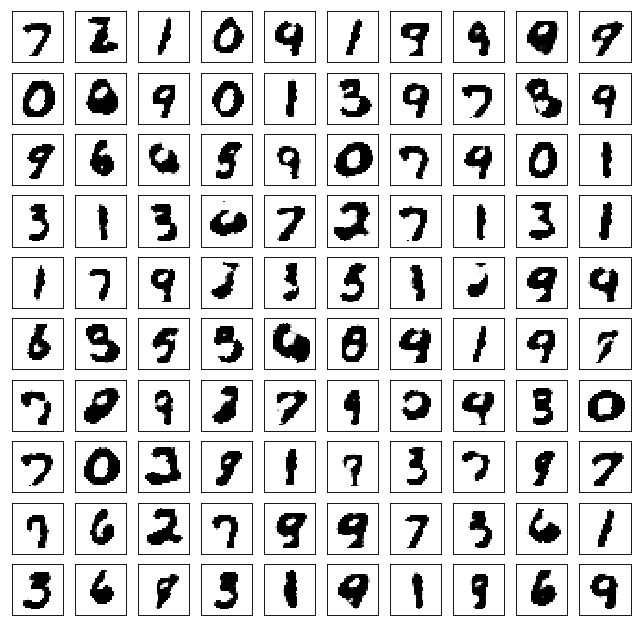

Test losses. VAE64: -6539137.8250
Train Epoch: 5 [0/50000 (0%)]	Losses VAE64: -6431607.5000
Train Epoch: 5 [25000/50000 (50%)]	Losses VAE64: -6673155.5000
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE64: -7046653.0000


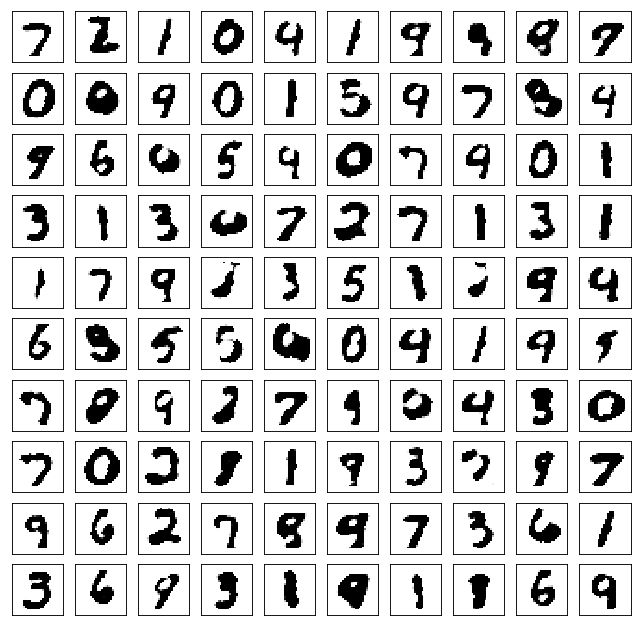

Test losses. VAE64: -7063443.0500
Train Epoch: 6 [0/50000 (0%)]	Losses VAE64: -7082435.0000
Train Epoch: 6 [25000/50000 (50%)]	Losses VAE64: -7138609.5000
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE64: -7416048.0000


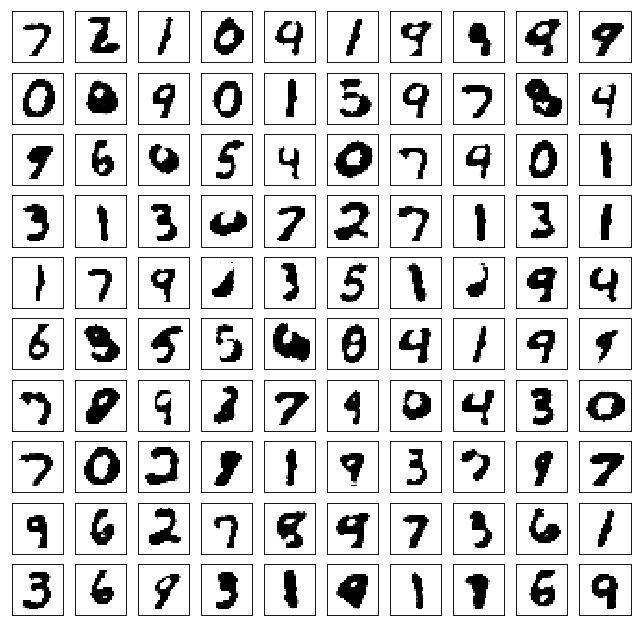

Test losses. VAE64: -7390073.6000
Train Epoch: 7 [0/50000 (0%)]	Losses VAE64: -7506899.0000
Train Epoch: 7 [25000/50000 (50%)]	Losses VAE64: -7455546.5000
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE64: -7648177.5000


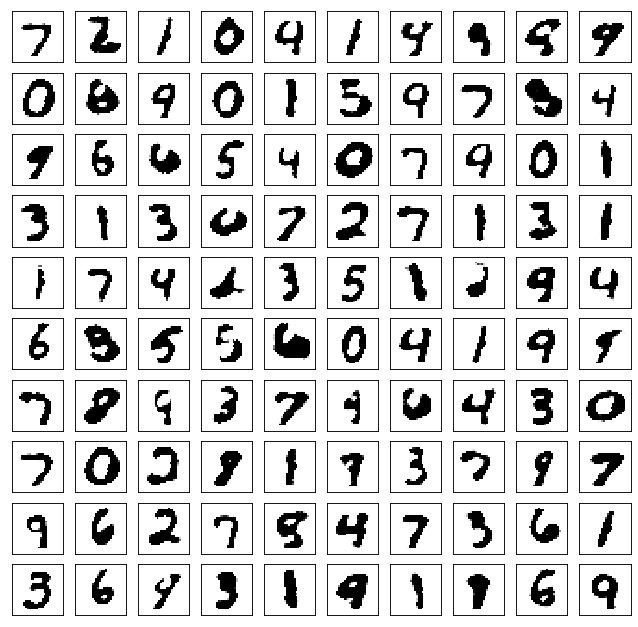

Test losses. VAE64: -7656488.5875
Train Epoch: 8 [0/50000 (0%)]	Losses VAE64: -7769419.5000
Train Epoch: 8 [25000/50000 (50%)]	Losses VAE64: -7678861.5000
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE64: -7777363.5000


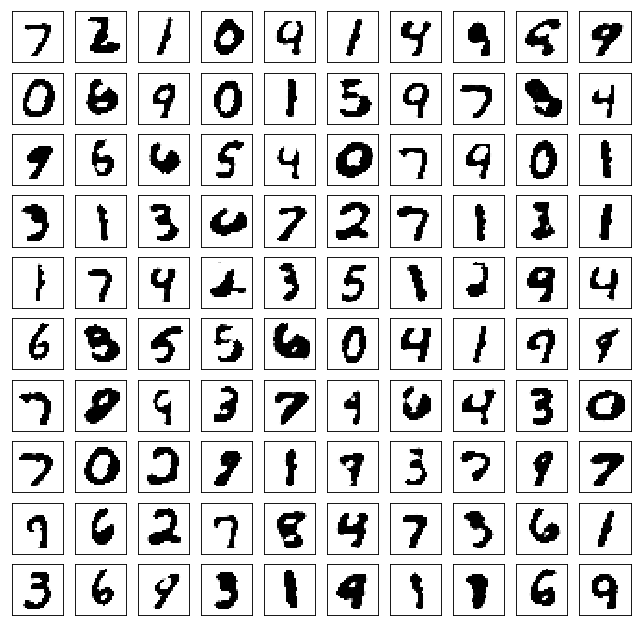

Test losses. VAE64: -7837322.2250
Train Epoch: 9 [0/50000 (0%)]	Losses VAE64: -7697134.0000
Train Epoch: 9 [25000/50000 (50%)]	Losses VAE64: -7902006.5000
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE64: -7796218.5000


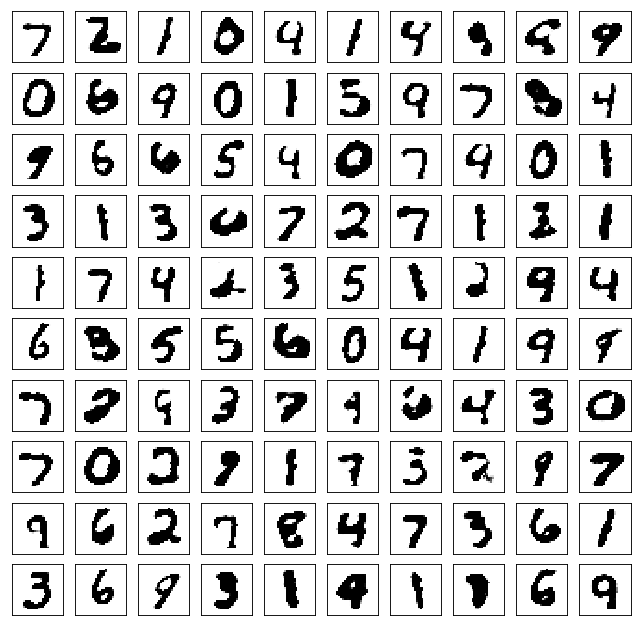

Test losses. VAE64: -7967842.5625
Train Epoch: 10 [0/50000 (0%)]	Losses VAE64: -7888365.5000
Train Epoch: 10 [25000/50000 (50%)]	Losses VAE64: -7948346.0000
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE64: -8104082.0000


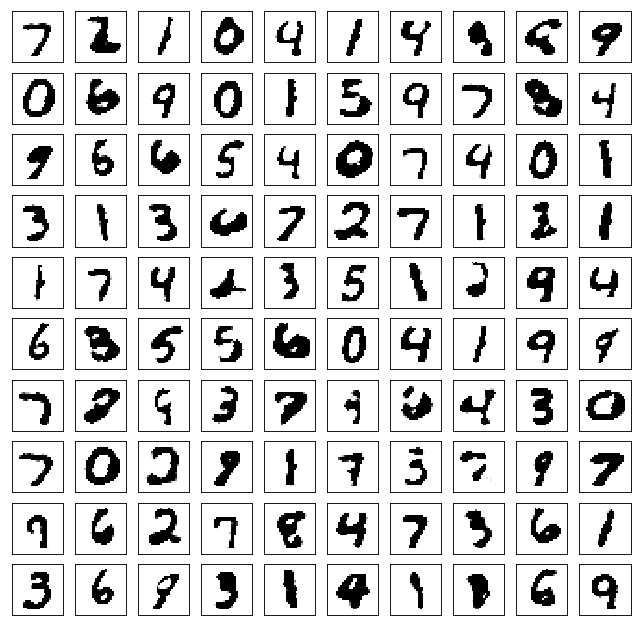

Test losses. VAE64: -8125795.1375


In [15]:
for name, model in models.items():
    full_recon_folder = recon_folder + name + '/'
    os.mkdir(full_recon_folder)
        
    for epoch in range(1, 11):
        model.train()
        train(model, epoch, train_log)
        model.eval()
        test(model, valid_loader, epoch, full_recon_folder, test_log)

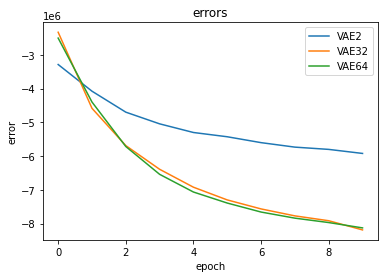

In [16]:
plot_graphs(test_log, 'loss')

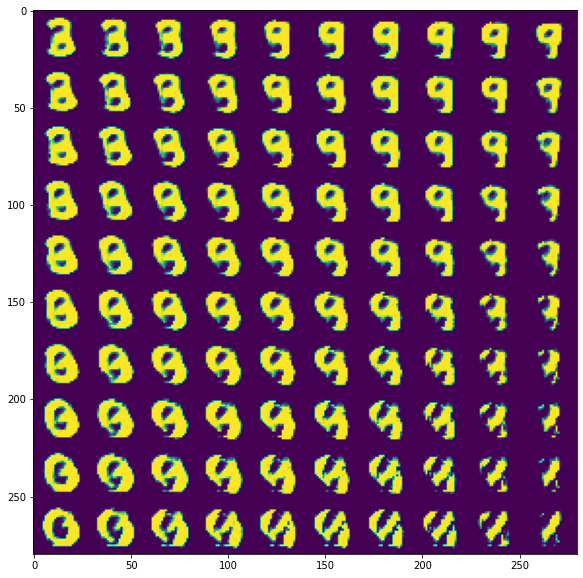

In [20]:
from scipy.stats import norm

n = 10  # 10x10 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        z_sample = torch.Tensor(z_sample).to(device)
        x_decoded = models['VAE2'].decoder(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.detach().cpu()

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()